In [4]:
%matplotlib inline

import os
import glob

import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

obs_color = "#3498db"
hist_color = "#34495e"
rcp_color = "#e74c3c"

In [5]:
#size = 'small'
size = 'medium'
#size = 'large'
#size = 'huc070812'

#lookup = pd.read_csv('/glade/p/ral/hap/mizukami/loca/GF-loca12k/output/selected/gaugeII/gageIInat.csv')
lookup = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/gageIInat_{size}.csv')
lookup = lookup.set_index('STAID')
lookup.head()

,seg_id2,HUC02,STATE,DRAIN_SQKM,LAT_GAGE,LNG_GAGE,STANAME
STAID,,,,,,,
1169000,1001367,1,MA,231,42.638418,-72.725092,NORTH RIVER AT SHATTUCKVILLE MA
2017500,2001874,2,VA,276,37.506240,-80.106715,JOHNS CREEK AT NEW CASTLE VA
2059500,3001379,3,VA,485,37.173200,-79.520308,GOOSE CREEK NEAR HUDDLESTON VA
4127997,4001071,4,MI,487,45.274457,-84.600031,STURGEON RIVER AT WOLVERINE MI
3070500,5000683,5,WV,517,39.615638,-79.704774,BIG SANDY CREEK AT ROCKVILLE WV


In [6]:
huc_mapping = {'1': '1-2', '2': '1-2',
               '3': '3',
               '4': '4-6', '5': '4-6', '6': '4-6',
               # ...
               '9': '7-10',
               '10L': '7-10', '10U': '7-10',
               '11': '11-16', '12': '11-16', '13': '11-16', '14': '11-16', '15': '11-16', '16': '11-16',
               '17': '17', '18': '18'}

def get_bcsd_df(seg, huc=None):
    if huc is None:
        huc_dir = '*'
    else:
        huc_dir = huc_mapping[huc]
        
    pattern = f'/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/{huc_dir}/*.routed.selected.nc'
    print(pattern, flush=True)
    files = glob.glob(pattern)
    index = xr.Variable('ens_member', ['_'.join(os.path.basename(f).split('.')[:2]) for f in files])
    ds = xr.open_mfdataset(files, concat_dim=index, data_vars='different')
    ds = ds.rename({'reachID': 'sSeg'}).set_coords('sSeg')

    df = ds.sel(sSeg=seg)['routedRunoff'].to_dataframe()
    df = df.drop(columns='sSeg')['routedRunoff'].unstack(level=0)
    return df

In [7]:
def get_loca_df(seg):
    files = glob.glob('/glade/p/ral/hap/mizukami/loca/GF-loca12k/output/selected/gaugeII/*.routed.selected.nc')
    index = xr.Variable('ens_member', ['_'.join(os.path.basename(f).split('.')[:2]) for f in files])
    ds = xr.open_mfdataset(files, concat_dim=index, data_vars='different')
    ds = ds.rename({'reachID': 'sSeg'}).set_coords('sSeg')

    df = ds.sel(sSeg=seg)['KWTroutedRunoff'].to_dataframe()
    df = df.drop(columns='sSeg')['KWTroutedRunoff'].unstack(level=0)
    return df

In [6]:
# def get_maurer_df(seg):
    
    
# def get_livneh_df(seg):
    
    

In [8]:
def get_obs(siteno):
    strnum = str(siteno).zfill(9)
    df = pd.read_table(f'/glade/work/mizukami/data/streamflow_obs/{strnum}_streamflow_1980_leap.txt',
                       sep=r"\s*", header=None, names=['siteno', 'year', 'month', 'day', 'streamflow']).reset_index()
    
    df.index = pd.to_datetime({'year': df.year, 'month': df.month, 'day': df.day})
    df = df.drop(columns=['index', 'siteno', 'year', 'month', 'day'])
    return df * 0.028


In [8]:
# df_obs = get_obs(12451000)
# df_bcsd = get_bcsd_df(17000507)
# df_loca = get_loca_df(17000507)

In [9]:
def plotting_positions(n, alpha=0.4, beta=0.4):
    '''Returns a monotonic array of plotting positions.
    Parameters
    ----------
    n : int
        Length of plotting positions to return.
    alpha, beta : float
        Plotting positions parameter. Default is 0.4.
    Returns
    -------
    positions : ndarray
        Quantile mapped data with shape from `input_data` and probability
            distribution from `data_to_match`.
    See Also
    --------
    scipy.stats.mstats.plotting_positions
    '''
    return (np.arange(1, n + 1) - alpha) / (n + 1. - alpha - beta)

In [10]:
def make_fdc_data(df):
    pps = plotting_positions(len(df))
    vals = np.sort(df.values, axis=0)[::-1]
    return pd.DataFrame(data=vals, index=pps, columns=df.columns)

In [17]:
df_bcsd

ens_member,access1-0_rcp45_r1i1p1_routed,access1-0_rcp85_r1i1p1_routed,bcc-csm1-1-m_rcp45_r1i1p1_routed,bcc-csm1-1-m_rcp85_r1i1p1_routed,bcc-csm1-1_rcp26_r1i1p1_routed,bcc-csm1-1_rcp45_r1i1p1_routed,bcc-csm1-1_rcp60_r1i1p1_routed,bcc-csm1-1_rcp85_r1i1p1_routed,canesm2_rcp26_r1i1p1_routed,canesm2_rcp45_r1i1p1_routed,...,mpi-esm-mr_rcp26_r1i1p1_routed,mpi-esm-mr_rcp45_r1i1p1_routed,mpi-esm-mr_rcp85_r1i1p1_routed,mri-cgcm3_rcp26_r1i1p1_routed,mri-cgcm3_rcp45_r1i1p1_routed,mri-cgcm3_rcp85_r1i1p1_routed,noresm1-m_rcp26_r1i1p1_routed,noresm1-m_rcp45_r1i1p1_routed,noresm1-m_rcp60_r1i1p1_routed,noresm1-m_rcp85_r1i1p1_routed
time,,,,,,,,,,,,,,,,,,,,,
1950-01-01,11.216244,11.257813,11.216251,11.217735,11.854866,11.217197,11.702348,12.703993,11.233992,11.217197,...,11.218354,11.218784,11.217197,11.218780,11.218788,11.218780,11.217830,11.217197,11.394775,11.217830
1950-01-02,16.686976,16.714912,16.687074,16.690918,17.986366,16.690067,17.013937,18.230577,17.448420,16.690067,...,16.691899,16.692574,16.689643,16.692574,16.692578,16.692574,16.689912,16.690067,16.794593,16.689912
1950-01-03,16.389151,16.400677,16.391216,16.395768,17.361908,16.396438,16.473148,17.545161,16.828086,16.395486,...,16.480670,16.397020,16.395904,16.398490,16.398491,16.398490,16.393665,16.396438,16.416204,16.393665
1950-01-04,15.750098,15.124956,15.119229,15.123681,15.452576,15.125694,15.136157,19.746171,15.200410,15.310379,...,15.347462,15.121580,15.443658,15.126450,15.126450,15.126450,15.121628,15.125694,15.126795,15.121628
1950-01-05,14.511323,13.851373,14.224457,13.851043,13.939617,13.853056,13.852776,18.972527,13.860500,14.147475,...,14.169860,13.845087,14.621097,13.854139,14.536209,13.854139,13.849702,13.853056,13.850144,13.849702
1950-01-06,12.982689,12.757811,13.028439,12.740078,12.815234,12.741915,12.740935,16.828132,12.897138,12.869760,...,12.960067,12.729867,13.613065,12.742486,13.141210,12.742486,12.738562,12.741915,12.737937,12.738562
1950-01-07,11.820839,11.774763,11.840203,11.763330,11.869329,11.765126,12.041834,15.870062,11.860458,12.684986,...,11.843734,11.751270,14.604869,11.766185,11.843462,11.766185,11.762098,11.765126,11.792578,11.762097
1950-01-08,10.912541,10.929346,10.904698,10.916288,11.164467,10.901668,11.282616,15.283376,10.929825,11.428978,...,10.915483,10.888018,12.866443,10.903191,10.916859,10.903191,10.898902,10.901668,10.916305,10.898901
1950-01-09,10.180860,10.330983,10.124672,10.143134,10.391360,10.135257,10.297154,14.617785,10.154446,10.240897,...,10.134446,10.120901,10.979355,10.136549,10.142317,10.136549,10.133172,10.135257,10.134708,10.133171


In [11]:
#make_fdc_data(df_bcsd).index

NameError: name 'df_bcsd' is not defined

In [12]:
def make_figure_1(outfilename=None, name=None, huc=None):
#def make_figure_1(outfilename=None, name=None):
    
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))
    # Why not displaying?
    
    for i, (df, label) in enumerate([(df_bcsd, 'BCSD'), (df_loca, 'LOCA')]):
        plt.sca(axes[i])

        hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
        rcp45 = make_fdc_data(df['2070': '2099'].filter(regex='rcp45'))
        rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))

        lines0 = plt.plot(hist.index, hist.values, color=hist_color, lw=0.5, alpha=0.5, zorder=10)
#         lines1 = plt.plot(rcp45.index, rcp45.values, color=rcp_color, lw=0.5, alpha=0.5)
        lines2 = plt.plot(rcp85.index, rcp85.values, color=rcp_color, lw=0.5, alpha=0.5)
        plt.yscale('log')
        plt.ylim(ymax=np.percentile(df['1970': '1999'], 99.999) * 1.1, ymin=np.percentile(df['1970': '1999'], 0.0001) * .9)
        plt.xlabel('Exceedance probability')
        plt.ylabel('Streamflow ($m^3 s^{-1})$')
        plt.title(label)

    plt.figlegend((lines0[0], lines2[0]), ('Historical', 'RCP 8.5'))
        
    
    if name:
        fig.suptitle(f'{name}, in HUC02:{huc}', y=1.02)
    
    if outfilename is not None:
        fig.savefig(outfilename, bbox_inches='tight', dpi=300)
        
       

In [29]:
# def make_figure_2(outfilename=None, gaugename=None):
#     fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))

#     for i, (df, label) in enumerate([(df_bcsd, 'BCSD'), (df_loca, 'LOCA')]):
#         plt.sca(axes[i])

#         hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
#         rcp45 = make_fdc_data(df['2070': '2099'].filter(regex='rcp45'))
#         rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))

#         lines0 = plt.plot(hist.index, hist.mean(axis=1).values, color=hist_color, lw=1, zorder=10)
# #         lines1 = plt.plot(rcp45.index, rcp45.mean(axis=1).values, color=rcp_color, lw=1)
#         lines2 = plt.plot(rcp85.index, rcp85.mean(axis=1).values, color=rcp_color, lw=1)
#         plt.yscale('log')
#         plt.ylim(ymax=np.percentile(df['1970': '1999'], 99.999) * 1.1, ymin=np.percentile(df['1970': '1999'], 0.0001) * .9)
#         plt.xlabel('Exceedance probability')
#         plt.ylabel('Streamflow ($m^3 s^{-1})$')
#         plt.title(label)

#     plt.figlegend((lines0[0], lines2[0], ), ('Historical', 'RCP 8.5'), loc='center right')
    
#     if gaugename:
#         plt.title(gaugename)
    
#     if outfilename is not None:
#         fig.savefig(outfilename)

In [13]:
def make_figure_2(outfilename=None, name=None, huc=None):

    fig, axes = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(12, 8))

    lines = []
    labels = []

    plt.sca(axes)
    obs = make_fdc_data(df_obs['1970': '1999'])
    obs_line = plt.plot(obs.index, obs.mean(axis=1).values, color=obs_color, lw=4, zorder=10, ls='-',)
    lines.append(obs_line[0])
    labels.append('Observations')

    for i, (df, label) in enumerate([(df_bcsd, 'BCSD'), (df_loca, 'LOCA')]):

        if i == 1:
            ls = '--'
        else:
            ls = '-'

        hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
        rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))

        lines0 = plt.plot(hist.index, hist.mean(axis=1).values, color=hist_color, lw=2, zorder=10, ls=ls)
    #     lines1 = plt.plot(rcp45.index, rcp45.mean(axis=1).values, color='orange', lw=2, ls=ls)
        lines2 = plt.plot(rcp85.index, rcp85.mean(axis=1).values, color=rcp_color, lw=2, ls=ls)
        plt.yscale('log')
        plt.xlabel('Exceedance probability')
        plt.ylabel('Streamflow ($m^3 s^{-1})$')

        lines.extend([lines0[0], lines2[0]])
        labels.extend([f'{label}-Historical', f'{label}-RCP 8.5'])

    plt.figlegend(lines, labels, loc='upper right')

    if name:
        plt.title(f'{name}, in HUC02:{huc}')
    
    if outfilename is not None:
        fig.savefig(outfilename, bbox_inches='tight', dpi=300)


In [ ]:
#help function
#plt.sca?
#row

/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/4-6/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/1-2/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/1-2/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/3/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/4-6/*.routed.selected.nc
skipping 4150500
[Errno 2] No such file or directory: '/glade/work/mizukami/data/streamflow_obs/004150500_streamflow_1980_leap.txt'
/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/4-6/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different 

/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/4-6/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


skipping 5489000
'7'
skipping 7291000
'8'
/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/7-10/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/11-16/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/11-16/*.routed.selected.nc
skipping 8070000
12000983
/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/11-16/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/11-16/*.routed.selected.nc


KeyboardInterrupt: 

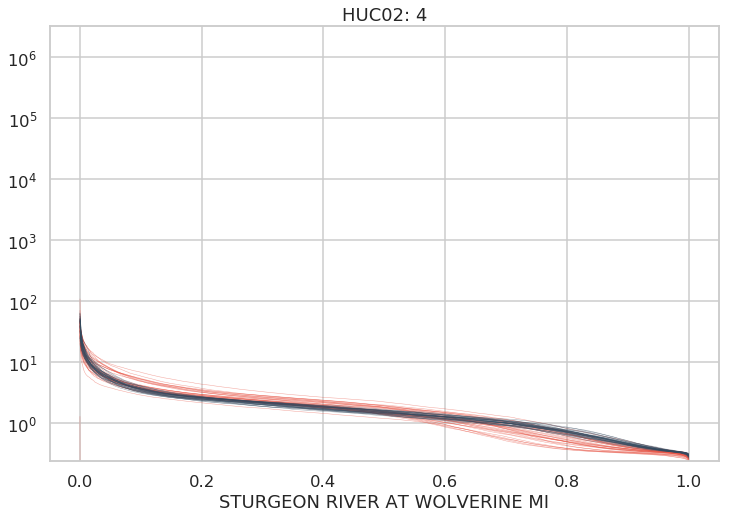

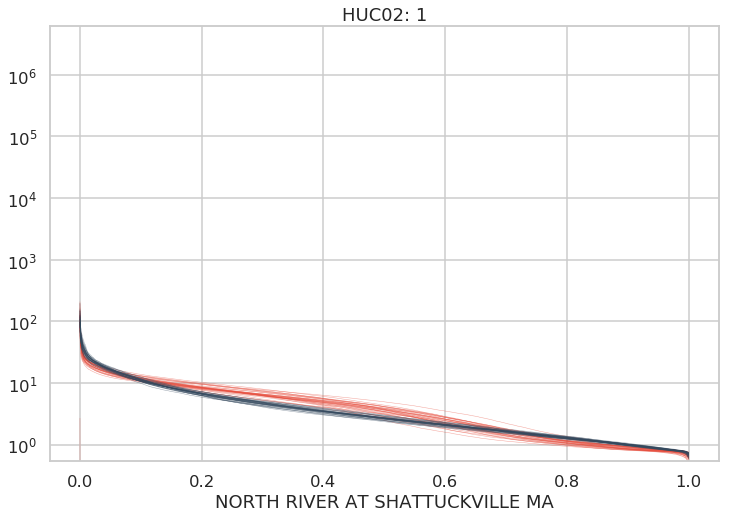

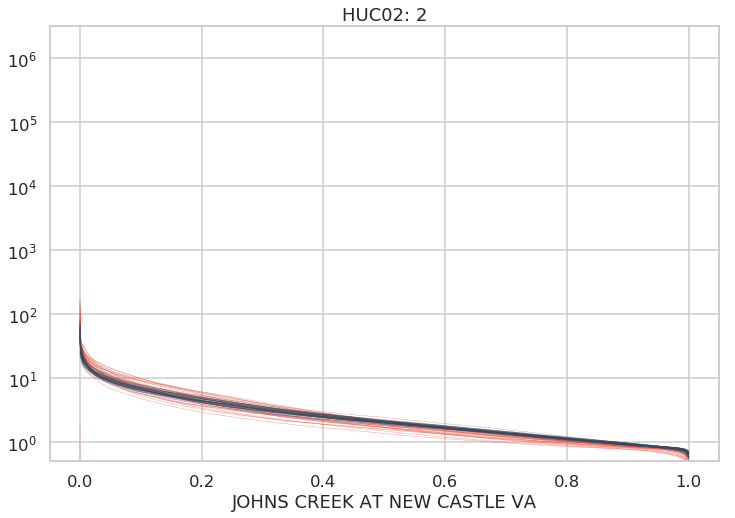

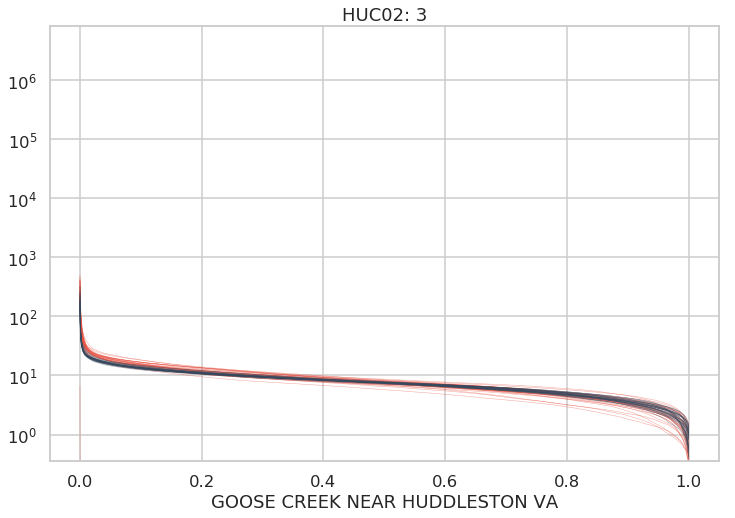

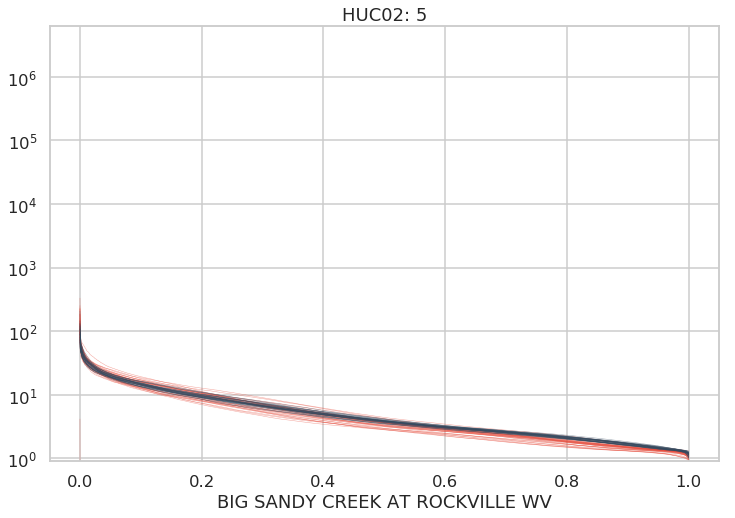

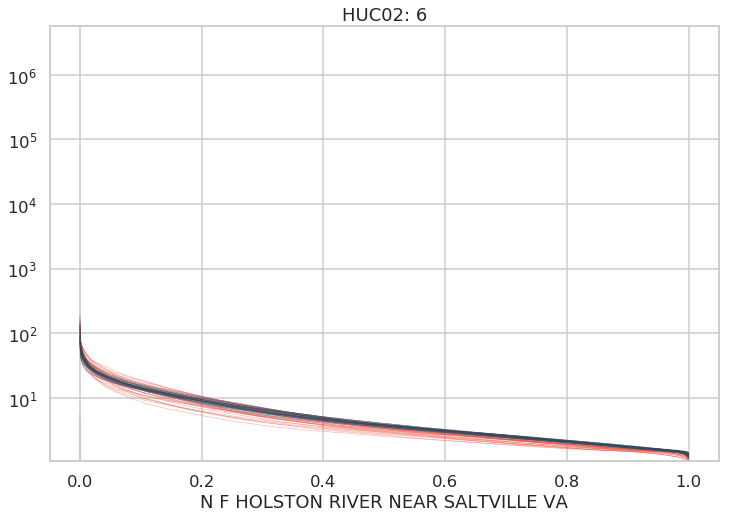

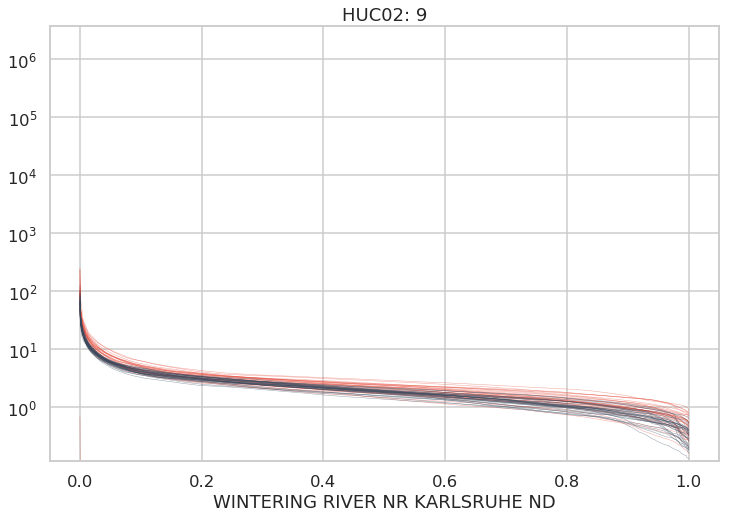

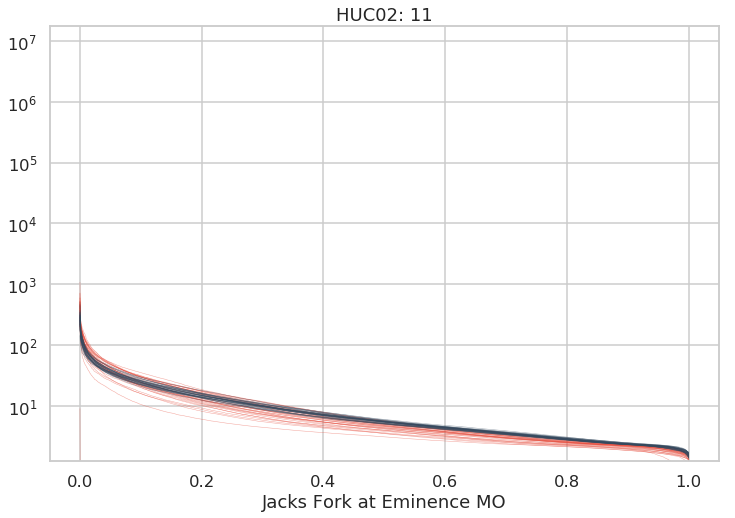

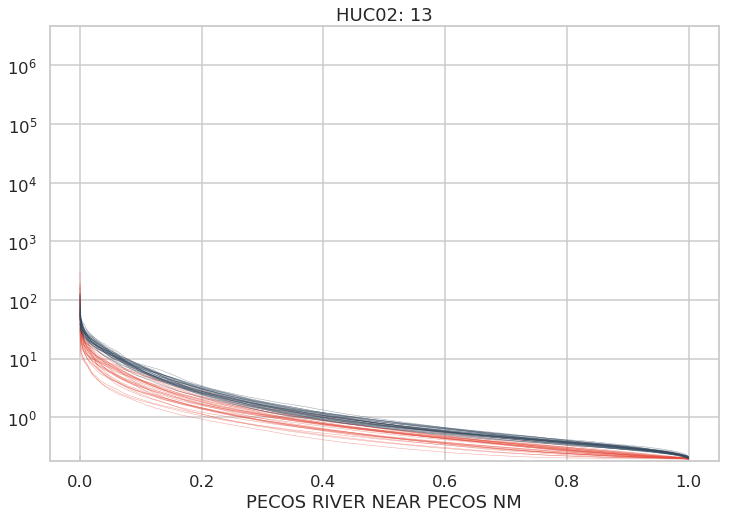

In [31]:
# THIS WORKS TO MAKE SINGLE PLOTS.  
def make_figure_3(outfilename=None, name=None, huc=None):
    
    fig, axes = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(12, 8), squeeze=False)
    
    for i, (df, label) in enumerate([(df_loca, 'LOCA')]):
        plt.sca(axes.flat[i])

        hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
        rcp45 = make_fdc_data(df['2070': '2099'].filter(regex='rcp45'))
        rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))

        lines0 = plt.plot(hist.index, hist.values, color=hist_color, lw=0.5, alpha=0.5, zorder=10)
#         lines1 = plt.plot(rcp45.index, rcp45.values, color=rcp_color, lw=0.5, alpha=0.5)
        lines2 = plt.plot(rcp85.index, rcp85.values, color=rcp_color, lw=0.5, alpha=0.5)
        plt.yscale('log')
        plt.ylim(ymax=np.percentile(df['1970': '1999'], 99.999) * 1.1, ymin=np.percentile(df['1970': '1999'], 0.0001) * .9)
#         plt.xlabel('Exceedance probability')
#         plt.ylabel('Streamflow ($m^3 s^{-1})$')
        plt.xlabel(name)
        plt.title(f'HUC02: {row.HUC02}')

    #plt.figlegend((lines0[0], lines2[0]), ('Historical', 'RCP 8.5'))
        
    
#     if name:
#         fig.suptitle(f'{name}, in HUC02:{huc}', y=1.02)
    
    if outfilename is not None:
        fig.savefig(outfilename, bbox_inches='tight', dpi=100)
        
        
        
for staid, row in lookup[lookup.LNG_GAGE < -70].iterrows(): 
    try:
        df_bcsd = get_bcsd_df(row.seg_id2, huc=row.HUC02)
        df_obs = get_obs(staid)
        df_loca = get_loca_df(row.seg_id2)

    except Exception as e:
        bad_ids.append(staid)
        print('skipping %s' % staid)
        print(e)
        continue
        
    #TODO add Huc to fig
    make_figure_3(outfilename=f'/glade/u/home/jvano/workdir/loca_figs/fdc_ensemble_loca_avg_{staid}_huc{row.HUC02}_{size}.png', name=row.STANAME, huc=row.HUC02)

KeyboardInterrupt: 

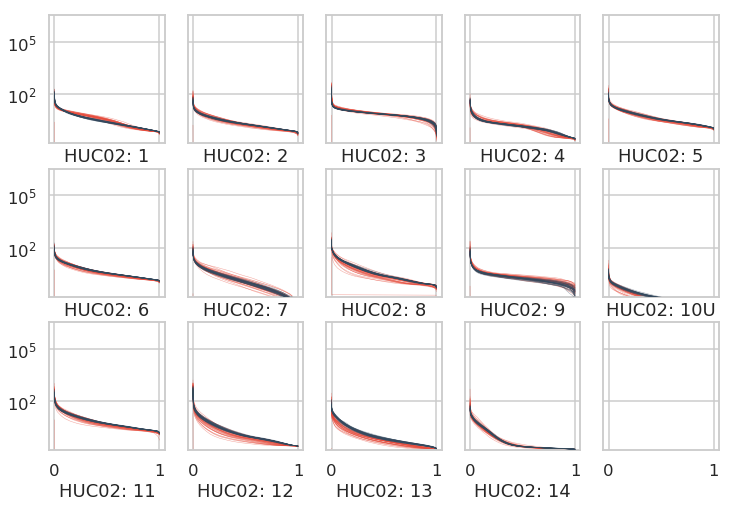

In [14]:
# TRYING TO REVISE SCRIPT TO MAKE IT LOOP OVER FILE.  
    
#fig, axes = plt.subplots(ncols=6, nrows=3, sharex=True, sharey=True, figsize=(12, 8), squeeze=False)
fig, axes = plt.subplots(ncols=5, nrows=3, sharex=True, sharey=True, figsize=(12, 8), squeeze=False)

for i, (staid, row) in enumerate(lookup[lookup.LNG_GAGE < -70].iterrows()):

    plt.sca(axes.flat[i])
    
#     df_bcsd = get_bcsd_df(row.seg_id2, huc=row.HUC02)
#     df_obs = get_obs(staid)
    df = get_loca_df(row.seg_id2)
    
    hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
    rcp45 = make_fdc_data(df['2070': '2099'].filter(regex='rcp45'))
    rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))
    
    lines0 = plt.plot(hist.index, hist.values, color=hist_color, lw=0.5, alpha=0.5, zorder=10)
    lines2 = plt.plot(rcp85.index, rcp85.values, color=rcp_color, lw=0.5, alpha=0.5)
    plt.yscale('log')
    plt.ylim(ymax=np.percentile(df['1970': '1999'], 99.999) * 1.1, ymin=np.percentile(df['1970': '1999'], 0.0001) * .9)
    #plt.xlabel(row.STANAME)
    #plt.title(f'HUC02: {row.HUC02}')
    plt.xlabel(f'HUC02: {row.HUC02}')
#     plt.figlegend((lines0[0], lines2[0]), ('Historical', 'RCP 8.5'))

# fig.savefig(outfilename=f'/glade/u/home/jvano/workdir/loca_figs/fdc_ensemble_{staid}_huc{row.HUC02}_{size}.png', bbox_inches='tight', dpi=100)

In [ ]:
#OLD ATTEMPTS THAT DIDN'T WORK
# for i, (staid, df) in enumerate (row in lookup[lookup.LNG_GAGE < -70].iterrows(), df_loca):
#     for i, (df, label) in enumerate([(df_loca, 'LOCA')]):
# for i, staid in enumerate(lookup.index[:i]):

In [63]:
#lookup[lookup.LNG_GAGE < -70].iterrows()
#row.HUC02
#row.staid
lookup['HUC02'].index


Int64Index([1169000], dtype='int64', name='STAID')

In [15]:
bad_ids = []
#for staid, row in lookup[lookup.LNG_GAGE < -100].iterrows(): 
for staid, row in lookup[lookup.LNG_GAGE < -70].iterrows(): 
    try:
        df_bcsd = get_bcsd_df(row.seg_id2, huc=row.HUC02)
        df_obs = get_obs(staid)
        df_loca = get_loca_df(row.seg_id2)

    except Exception as e:
        bad_ids.append(staid)
        print('skipping %s' % staid)
        print(e)
        continue
        
#TODO add Huc to fig
    make_figure_1(outfilename=f'/glade/u/home/jvano/workdir/loca_figs/fdc_ensemble_{staid}_huc{row.HUC02}_{size}.png', name=row.STANAME, huc=row.HUC02)
    make_figure_2(outfilename=f'/glade/u/home/jvano/workdir/loca_figs/fdc_ensemble_avg_{staid}_huc{row.HUC02}_{size}.png', name=row.STANAME, huc=row.HUC02)
#     make_figure_1(outfilename=f'/glade/u/home/jhamman/workdir/loca_figs/fdc_ensemble_{staid}.png', name=row.STANAME)
#     make_figure_2(outfilename=f'/glade/u/home/jhamman/workdir/loca_figs/fdc_ensemble_avg_{staid}.png', name=row.STANAME)

/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/4-6/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/1-2/*.routed.selected.nc


/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


KeyboardInterrupt: 

In [ ]:
bad_ids